In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%bash
cp /content/drive/MyDrive/course/data.zip /content/data.zip

In [ ]:

%%bash
cd /content
unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/apple/
  inflating: data/apple/img_0.jpg    
  inflating: data/apple/img_1.jpg    
  inflating: data/apple/img_10.jpg   
  inflating: data/apple/img_100.jpg  
  inflating: data/apple/img_101.jpg  
  inflating: data/apple/img_102.jpg  
  inflating: data/apple/img_103.jpg  
  inflating: data/apple/img_104.jpg  
  inflating: data/apple/img_105.jpg  
  inflating: data/apple/img_106.jpg  
  inflating: data/apple/img_107.jpg  
  inflating: data/apple/img_108.jpg  
  inflating: data/apple/img_109.jpg  
  inflating: data/apple/img_11.jpg   
  inflating: data/apple/img_110.jpg  
  inflating: data/apple/img_111.jpg  
  inflating: data/apple/img_112.jpg  
  inflating: data/apple/img_113.jpg  
  inflating: data/apple/img_114.jpg  
  inflating: data/apple/img_115.jpg  
  inflating: data/apple/img_116.jpg  
  inflating: data/apple/img_117.jpg  
  inflating: data/apple/img_118.jpg  
  inflating: data/apple/img_119.jpg  
  inflating: data/apple/i

In [ ]:
!pip install keras-cv tensorflow --upgrade

In [ ]:
!pip install keras-core

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import keras_cv


In [ ]:
tf.__version__

'2.17.0'

In [ ]:
DATA_DIR = '/content/data'
CLASSES = sorted(os.listdir(DATA_DIR))


In [ ]:
data = {
    class_name: len(os.listdir(os.path.join(DATA_DIR, class_name)))
    for class_name in CLASSES
}


In [ ]:
ingredients = list(data.keys())
counts = list(data.values())

Text(0.5, 1.0, 'Number of images for each Ingredient ')

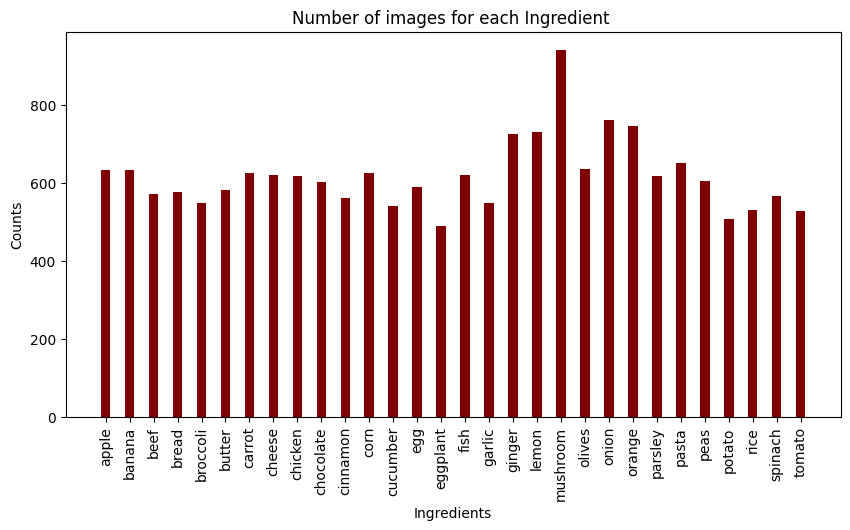

In [ ]:
fig  = plt.figure(figsize = (10, 5))
plt.bar(ingredients, counts, color = 'maroon', width = 0.4)
plt.xticks(range(len(ingredients)), ingredients, rotation = 'vertical')
plt.xlabel("Ingredients")
plt.ylabel("Counts")
plt.title("Number of images for each Ingredient ")

In [ ]:
 train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="int",
    class_names=CLASSES,
    color_mode="rgb",
    batch_size=64,
    image_size=(224, 224),
    validation_split=0.1,
    subset="both",
    seed=100,
    shuffle=True,
)

Found 18517 files belonging to 30 classes.
Using 16666 files for training.
Using 1851 files for validation.


In [ ]:
sample_data = list(train_ds.take(1))

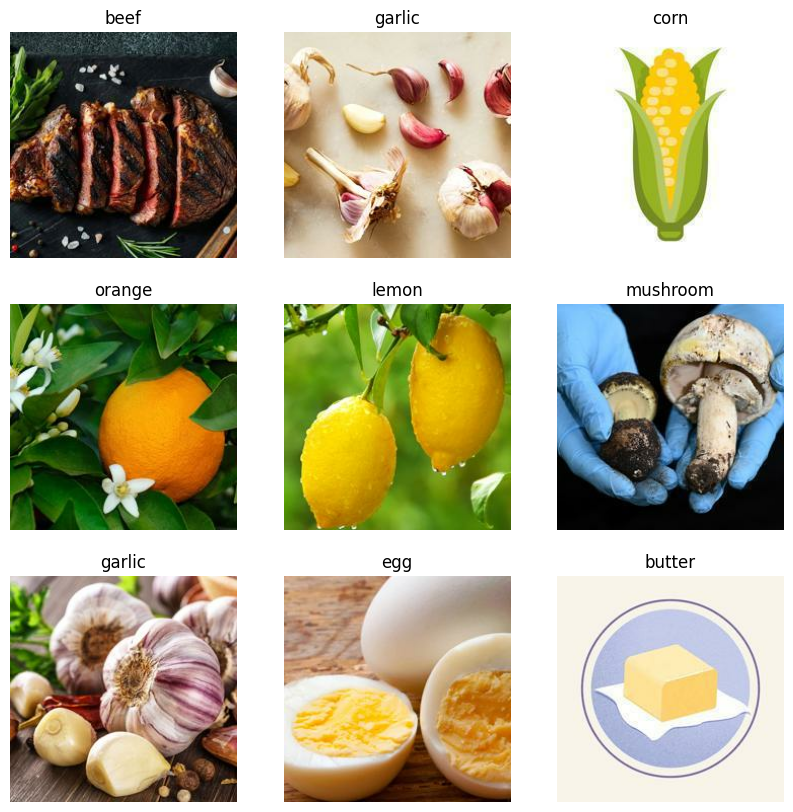

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASSES[int(labels[i])])
        plt.axis("off")

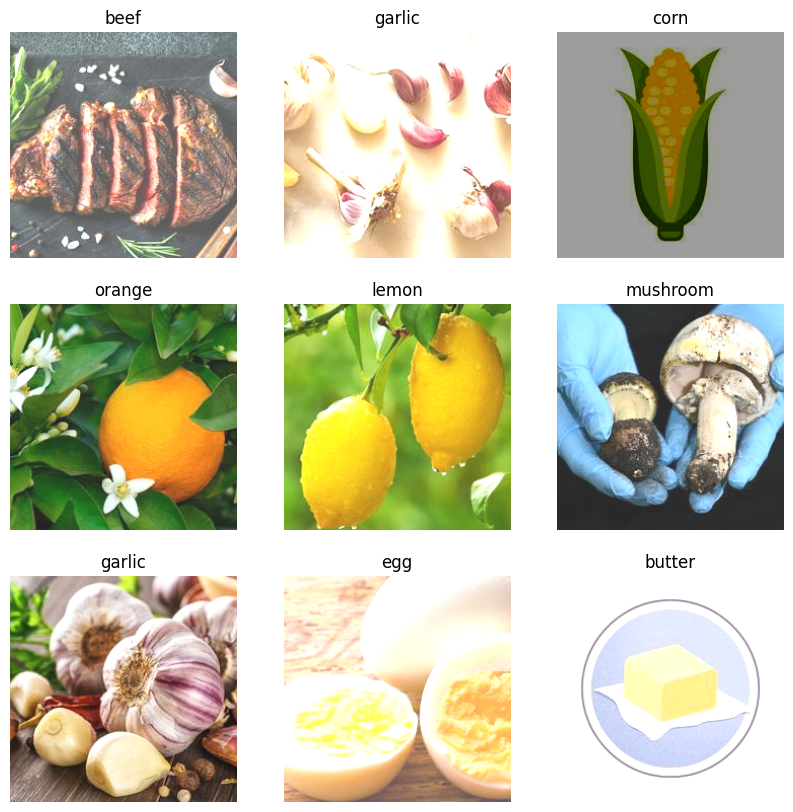

In [ ]:


plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = layers.RandomBrightness(factor=0.4, value_range=(0, 255))(images[i])
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(CLASSES[int(labels[i])])
        plt.axis("off")

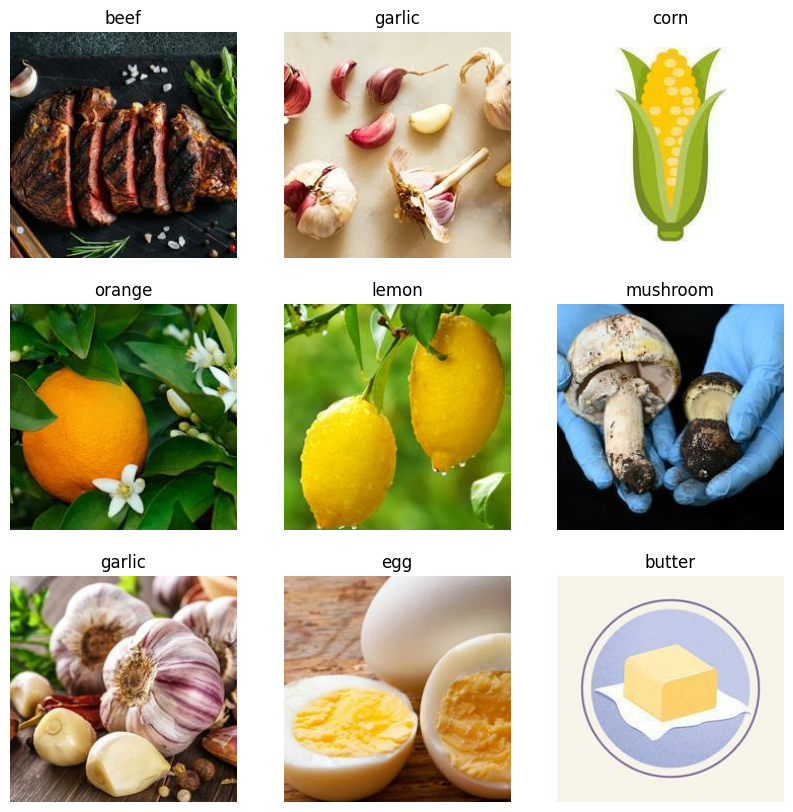

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = layers.RandomFlip("horizontal")(images[i])
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(CLASSES[int(labels[i])])
        plt.axis("off")

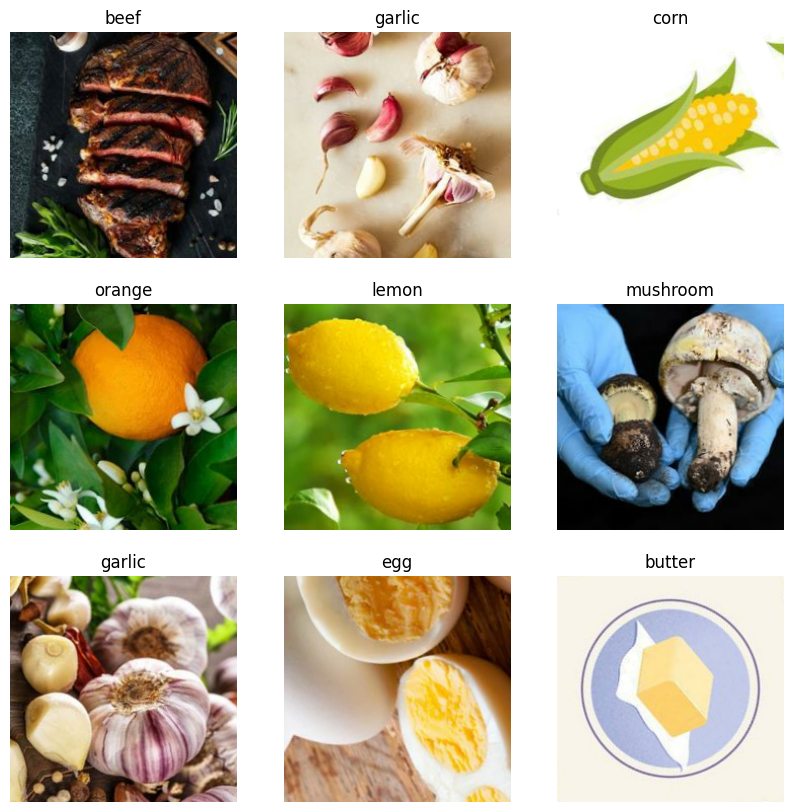

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = layers.RandomRotation(0.5)(images[i])
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(CLASSES[int(labels[i])])
        plt.axis("off")

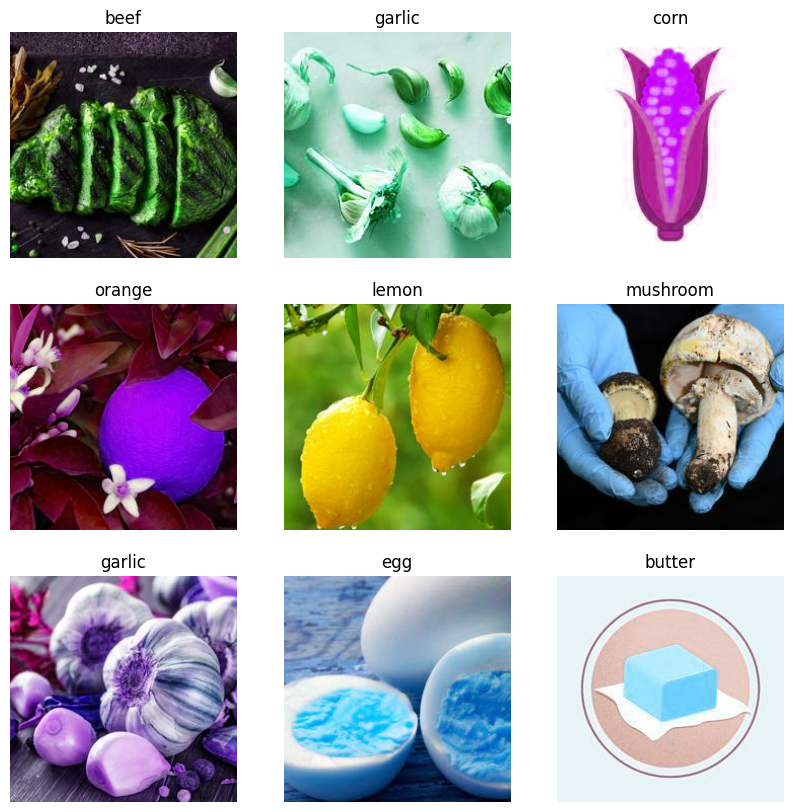

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = keras_cv.layers.ChannelShuffle()(images[i])
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(CLASSES[int(labels[i])])
        plt.axis("off")

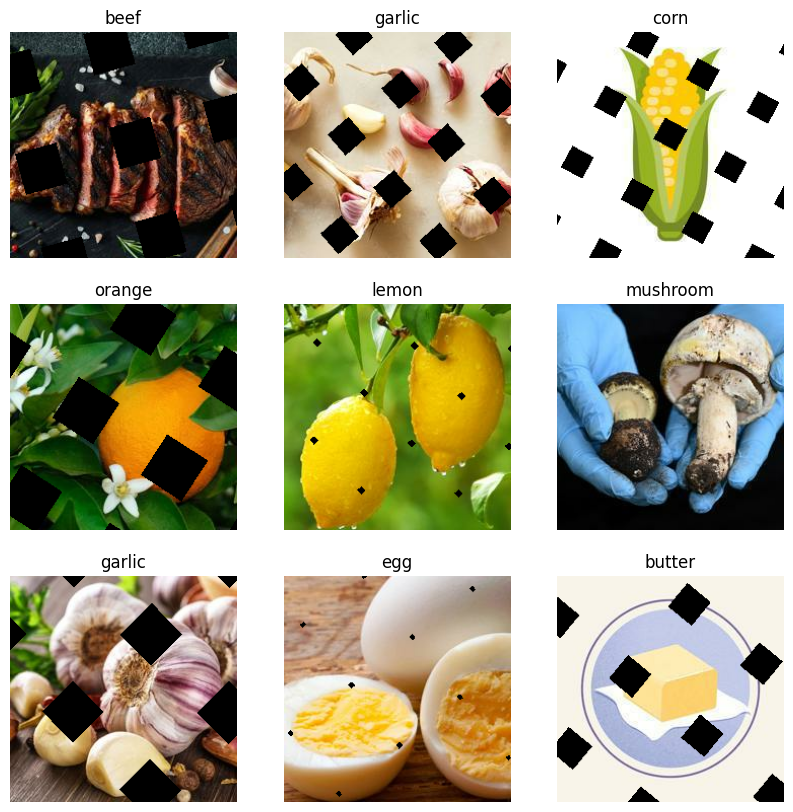

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in sample_data:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = keras_cv.layers.GridMask()(images[i])
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(CLASSES[int(labels[i])])
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomBrightness(factor=0.4, value_range=(0, 255)),
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.5),
        keras_cv.layers.ChannelShuffle(),
        keras_cv.layers.GridMask(),
    ]
)


train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:

L2_LAMBDA = 1e-5
IMAGE_SIZE = (224, 224)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = layers.Rescaling(1.0 / 255)(inputs)

    x = layers.Conv2D(32, 3, strides=1, padding="same", kernel_regularizer=regularizers.L2(L2_LAMBDA))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("gelu")(x)
    x = layers.Conv2D(32, 3, strides=1, padding="same", kernel_regularizer=regularizers.L2(L2_LAMBDA))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("gelu")(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same", kernel_regularizer=regularizers.L2(L2_LAMBDA))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("gelu")(x)

    for size in [64, 128, 256, 512]:
        x = layers.Conv2D(size, 3, kernel_regularizer=regularizers.L2(L2_LAMBDA), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("gelu")(x)

        x = layers.Conv2D(size, 3, kernel_regularizer=regularizers.L2(L2_LAMBDA), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("gelu")(x)

        x = layers.Conv2D(size, 3, kernel_regularizer=regularizers.L2(L2_LAMBDA), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("gelu")(x)

        x = layers.MaxPooling2D(3, strides=2)(x)


    x = layers.GlobalMaxPooling2D()(x)

    x = layers.Dense(256, activation="gelu",
                  activity_regularizer=regularizers.L2(L2_LAMBDA) )(x)

    x = layers.Dense(256, activation="gelu",

    activity_regularizer=regularizers.L2(L2_LAMBDA) )(x)


    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=IMAGE_SIZE + (3,), num_classes=30)

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/cps/save_at_{epoch}.keras"),
]


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds
)

Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.0679 - loss: 3.4855 - val_accuracy: 0.0600 - val_loss: 3.9407
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.1058 - loss: 3.1466 - val_accuracy: 0.0859 - val_loss: 3.2242
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.1147 - loss: 3.1113 - val_accuracy: 0.0665 - val_loss: 3.7508
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.1198 - loss: 3.0408 - val_accuracy: 0.0940 - val_loss: 3.6571
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 342s 1s/step - accuracy: 0.1558 - loss: 2.9281 - val_accuracy: 0.1270 - val_loss: 4.1034
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 388s 1s/step - accuracy: 0.1826 - loss: 2.8140 - val_accuracy: 0.1713 - val_loss: 3.0408
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - accuracy: 0.2146 - loss: 2.7079 - val_accuracy: 0.1405 - val_loss: 3.5722
Epoch 8/30
 56/261 ━━━━━━━━━━━━━━━━━━━━ 4:11 1s/step - accuracy: 0.2239 - loss: 2.6134

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loaded_model = tf.keras.models.load_model("/content/cps/save_at_30.keras")

In [ ]:
plt.figure(figsize=(21, 21))
for images, labels in val_ds.take(1):
    for i in range(6*6):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        img_array = tf.expand_dims(images[i].numpy().astype("uint8"), 0)  # Create batch axis
        preds = loaded_model.predict(img_array)
        plt.title(CLASSES[np.argmax(preds[0])])
        plt.axis("off")